In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


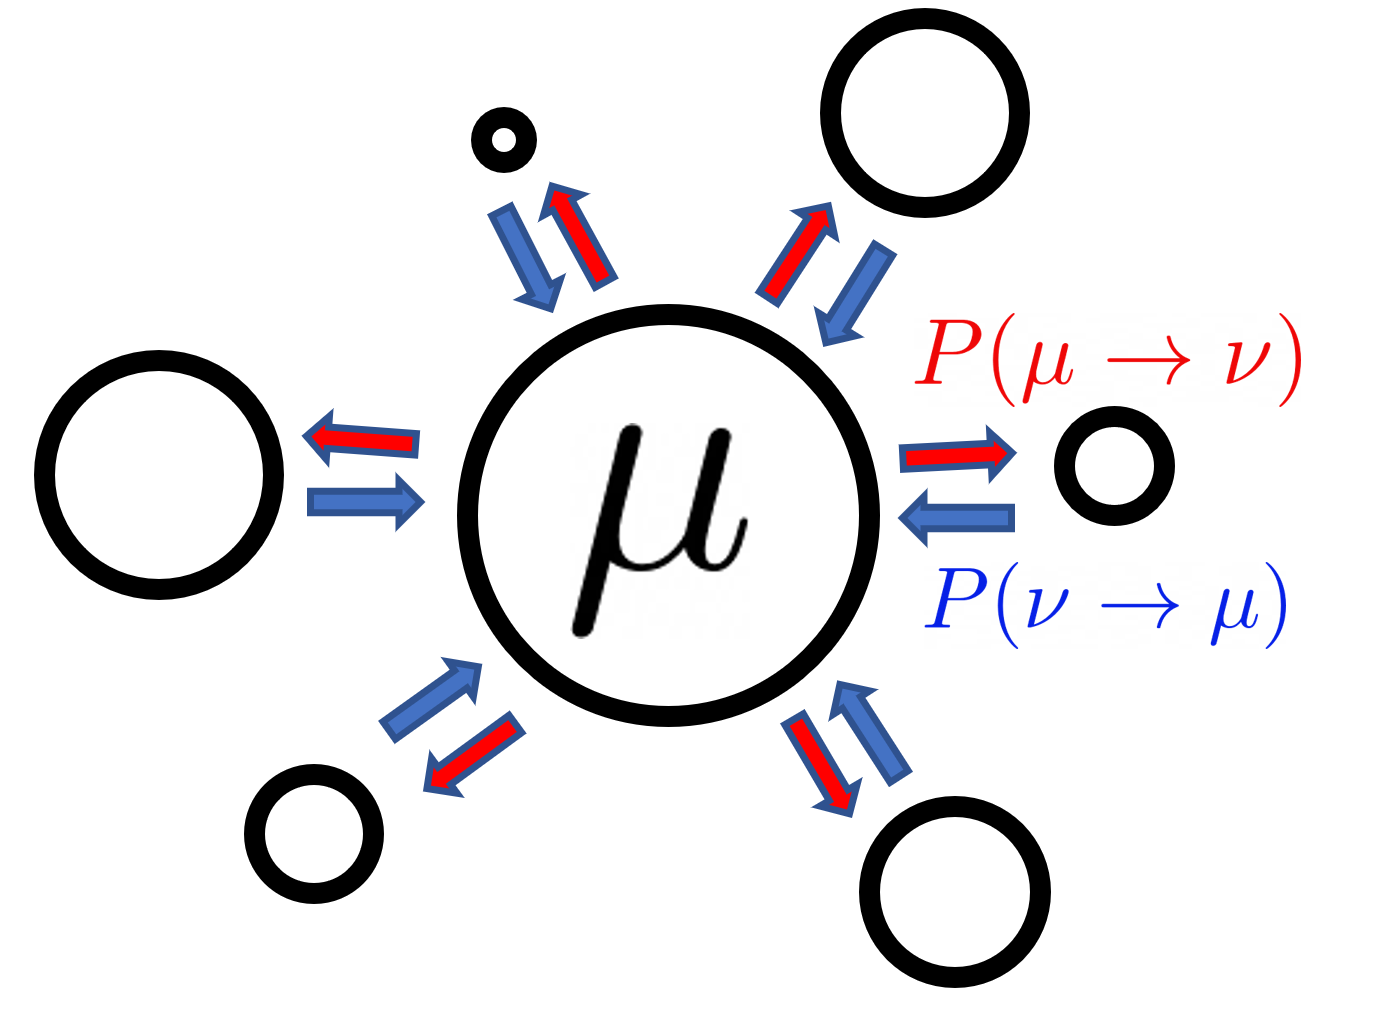

In [5]:
%matplotlib inline
from IPython.display import Image
Image('D:/Programming/Tutorials/GPUPython/vid14_p1.PNG')

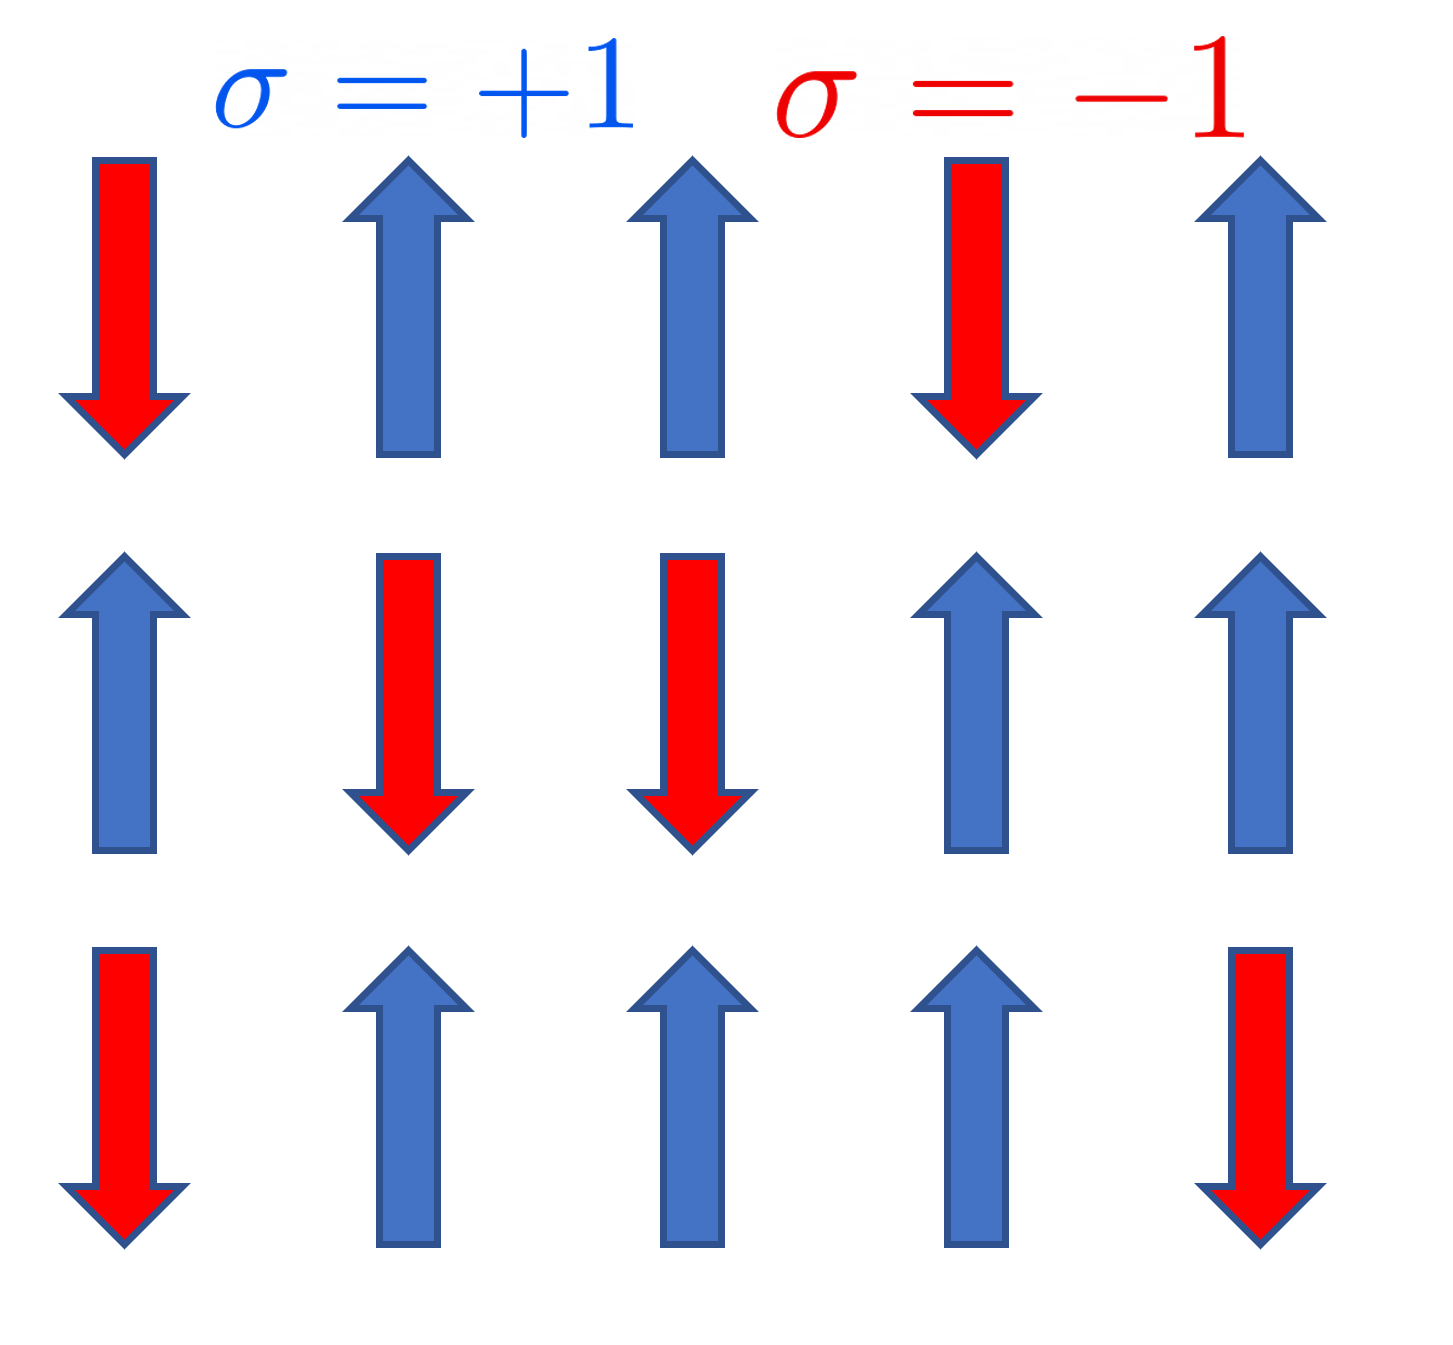

In [6]:
Image('D:/Programming/Tutorials/GPUPython/vid14_p2.PNG')

## ISING model
The study of the magnetisation of a material as a function of temperature of the material $M(T)$.
For example a bar magnet heated up loses it's magnetisation.
At lower temperatures the spins of atoms are alligned causing magnetisation, but at higher temperatures when we heat it up we provide enough energy for the spins to dissalign causing a net 0 magnetisation.

# Required Facts

A system in thermal equilibrium with a temperature bath. Probability $p_\mu$ of being in state $\mu$ with energy $E_\mu$ is

 $$p_\mu = \frac{1}{Z} e^{-\beta E_\mu} $$
 
where $Z = \sum_\mu e^{-\beta E_\mu}$ is the **partition function**. At equilbrium, the following must be true

$$\sum_\nu p_\mu P(\mu \to \nu) = \sum_\nu p_\nu P(\nu \to \mu)$$

where $P(\mu \to \nu)$ is the probability of going from state $\mu$ to $\nu$. 

"You're going out of the state as much as you're coming into the state => equillibrium"
A spin flip is an example of changing a state


For our numerical methods, this is difficult to enforce, but we can make it be true be setting the **detailed balance condition**

$$p_\mu P(\mu \to \nu) =p_\nu P(\nu \to \mu)$$

This true when

$$\frac{P(\mu \to \nu)}{P(\nu \to \mu)} = \frac{p_\nu}{p_\mu} = e^{-\beta (E_\nu-E_\mu)}$$

"Basiccaly saying, the ration of going between one state into the other and vice versa, is equal to the difference energy of these states"

<p align="center">
  <img src="../images/vid14_p1.PNG" alt="drawing" width="400" align="center"/>
</p>
![vid14_p1](D:/Programming/Tutorials/GPUPython/vid14_p1.PNG)



# Ising Model

The Ising model is a model of magnetization and gives us the energies needed to to evaluate the equation above

"You have to look at the neighbouring states, if all are spin up then it's a higher energy difference for this state to be spin down, therefore a smaller probability for that energy"

<p align="center">
  <img src="../images/vid14_p2.PNG" alt="drawing" width="300" align="center"/>
</p>

The total energy is

$$E_\mu = \sum_i \sum_{j \in N_i} -J\sigma_i \sigma_j $$

where 

* $i$ corresponds to the index of a point in the lattice
* $N_i$ is a set of indices corresponding to the nearest neighbours to that point. In 2D, there are 4 neighbours (left/right, above/below) and in 3D there are 6 neighbours (also front/back)
* $\sigma_i$ is the spin (-1 or +1) of point $i$
* $\mu$ corresponds to a particular configuration of the spins.


# Metropolis Algorithm

"The idea behind the simulation is to start with random spins at given temperature, and through iteration we adjust the spins until it reaches equillibrium (detailed balance condition).
If you enforce this condition at each iteration it will eventually move into that state of detailed balance."

**The Idea**: We want this to hold:

$$\frac{P(\mu \to \nu)}{P(\nu \to \mu)} = \frac{p_\nu}{p_\mu} = e^{-\beta (E_\nu-E_\mu)}$$

We'll simulate the system changing states from $\mu$ to different states $\nu$ at equilibrium, but we need to enforce the equation above.

1. Call the current state $\mu$. 
2. Pick a random particle on the lattice and flip the spin sign. Call the state $\nu$. We want to find the probability that $P(\mu \to \nu)$ that we'll accept this new state
3. * If $E_\nu > E_\mu$ then set $P(\nu \to \mu) = 1$ and thus by the detailed balance equation $P(\mu \to \nu) = e^{-\beta (E_\nu-E_\mu)}$. 
    * if $E_\mu > E_\nu$ then the rule above implies $P(\mu \to \nu) = 1$
4. Change to state $\nu$ (i.e. flip the spin of the particle) with the probabilities outlined above. 
5. Go back to step 1. Repeat the whole thing many many times and eventually you'll force out an equilbrium state. 

"This is basically a Monte Carlo simulation"

In [7]:
# 1000 by 1000 grid
N = 1000

Generate some initial random grids of spins

In [8]:
init_random = torch.rand((N,N)).to(device)
lattice_n = torch.zeros((N, N)).to(device)
lattice_n[init_random>=0.75] = 1    
lattice_n[init_random<0.75] = -1    # 75% pointing down

init_random = torch.rand((N,N)).to(device)
lattice_p = torch.zeros((N, N)).to(device)
lattice_p[init_random>=0.25] = 1    # 75% pointing up
lattice_p[init_random<0.25] = -1

Show initial lattice of spins

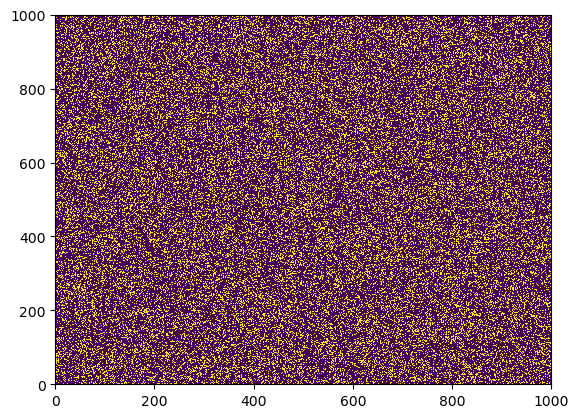

In [9]:
# this is the starting point of a 1000 atoms the mostly negative one
plt.pcolormesh(lattice_n.cpu()) 
plt.show()

Functions to compute

* the energy ( $E_i/J = -\sum_{j \in N_i} \sigma_i\sigma_j$) for each element $i$ in the lattice
* the total energy ( $E/J = -\sum_i \sum_{j \in N_i} \sigma_i\sigma_j$)of the lattice
* the change in energy ($\Delta E/J =  -2\sum_{j \in N_i} \sigma_i\sigma_j$) for each element in the lattice (if the spin were to flip)

Note that since we're using PyTorch's `conv2d` function, we have to be very careful about the input and kernel dimensionality:

* The first argument (input) has shape `[batch_size, in_channels, H, W]`
* The second argument (weight) has shape `[out_channels, in_channels, H, W]`

In our case, we aren't mixing over channels, so `in_channels=out_channels=`. The batch size we can use to our advantage if we want to perform convolutions over multiple lattices at the same time.

In [18]:
kern = generate_binary_structure(2, 1) 
kern[1][1] = False
kern    # 2D convolution kernel giving acces to the nearest neighbourghs of a point

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [19]:
"""
Have to be very careful with the dimensionality when converting the kernel
 into a pytorch tensor
The shape of the kernel is 1x1x3x3 and it looks like the boolean one converted to 1 and 0
Being careful with this is due to the convolution for pytorch being built
 for neural network so the arguments / shape tells you something different that numpy
 `[batch_size, in_channels, H, W]`, height and width is the 3x3, 
 batch_size tells you over how many of the stacks of lattices to perform conv
input_channels is crucial for ML, in our case each point in space we associate with
 a single number - its spin, if you associated that point with multiple variables 
 like spin, density, ... you'd have multiple channels, here we only have 1,
 but we need to keep the dimensionality correct when inputing into our convolution
output_channels is the same as input in our case because we're taking in spin at
 each point and outputting the energy of that point, nothing else
 
The way we do this (add the 1x1 in front) is with the .unsqueeze(dim=0), that
 puts a dimension at the beggining
"""

kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
kern.shape  # torch.Size([1, 1, 3, 3])

torch.Size([1, 1, 3, 3])

In [20]:
"""
One of the advantages of using torch and GPU is that we can evaluate a function
 for different lattices (each lattice is at a different set Temperature) unlike 
 with CPU where we'd have to do it iteratively, here we can batch.
"""

def get_energy_arr(lattices):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    # The convolution is equivalent to the sum over nearest neighbourghs with the use of our kernel
    arr = -lattices * conv2d(lattices, kern, padding='same')
    return arr
    
def get_energy(lattices):
    # applies the nearest neighbours summation
    """
    Because we have multiple lattices batched together, when we perform the operation
     and get energy for each point in the lattice, we want to sum up to get the 
     total energy of the lattice but for each individual lattice, therefore
     we have to specify axes over which to sum, in this case .sum(axis=(1,2,3))
     refers to summing over input_channel, height and witdth (so spins of the whole plane)
     but not over both lattices which would mix up our two separate lattices
    That's why in our case we get as answer an array with 2 items, corresponding
     to energy for each lattice in our batch
    """
    
    return get_energy_arr(lattices).sum(axis=(1,2,3))

def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

We can create a batch of lattices corresponding to the two lattices we created above

In [21]:
"""
lattice_n.shape
For just 1 lattice (in this case the one with 75% spins being down)
 the shape is: torch.Size([1000, 1000])

torch.stack([lattice_n, lattice_p]).shape
Now we stack these two lattices and we have dimension: 
 torch.Size([2, 1000, 1000])
 
torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1),.shape
We still need to add the channel dimension to make the convolution possible
 so we unsqueeze at dimension=1 to add it at the right "index"/dimension
 Shape is: torch.Size([2, 1, 1000, 1000])
"""
lattice_n.shape
torch.stack([lattice_n, lattice_p]).shape
torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1).shape

torch.Size([2, 1, 1000, 1000])

In [22]:
lattices = torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1)
lattices.shape

torch.Size([2, 1, 1000, 1000])

We can now compute the energy for these two lattices at the same time, since they have the necessary shape for feeding into the `get_energy_arr` algorithm

In [23]:
get_energy_arr(lattices).shape

torch.Size([2, 1, 1000, 1000])

In [24]:
# This is where we see that we got two answers, one for each lattice in our batch
get_energy(lattices).shape  

torch.Size([2])

**The metropolis algorithm**:

* Takes in a batch of 2D tensors of spins (shape `[batch_size, 1, H, W]`), number of time steps to run algoritm for, and temperatures $\beta J$ of length `batch_size` corresponding to the temperature for each 2D lattice
* Returns the spin and energy as a function of iteration number for each lattice

In [ ]:
# Ignore this code this is for learning purposes how it looks for CPU
"""
spin_arr - we start with initial array of spins, random, 75% up 25% down
we run the metropolis algorithm and the spins will arange in such a way that it 
 reaches an equillibrium/ what the true state should be at given temperature T
n_iterations - number of iterations

Then we first generate random number 0 or 1, 50% chance so that when we 
 take the energy of a given point and flip it's spin, if we flip the spins
 of neighbouring points it fucks with the energy
 dE = get_dE_arr(spin_arr)[i::2,j::2]  <- this part
 dE.shape   500x500
 
Then we gotta decide if this change in dE is positive or negative as in
 does it bring us closer to equillibrium or not, and with that decide to
 keep or discard this change (look up the 3.rd point in desciption of 
 the Metropolis algorithm)
change = (dE>=0)*(np.random.random(dE.shape) < np.exp(-BJ*dE)) + (dE<0)
 the first part with random.random it needs to satisfy the probability of dE >0 being
 less than <np.exp..., but for dE<0 the change is implied to be 1 so yes

spin_arr[i::2,j::2][change] *= -1
 we then index on the points where change is the mask of boolean values whether 
 to flip or not and we just flip the value
 
Then we just also note the energy and avg spin

For the CPU code we only do this for a single value of BJ - betta J
 bassically for a single temperature
"""

def metropolis(spin_arr, n_iterations, BJ):
    energies = []
    avg_spins = []
    spin_arr = spin_arr.copy()
    for t in range(n_iterations):
        i = np.random.randint(0, 2)
        j = np.random.randint(0, 2)
        dE = get_dE_arr(spin_arr)[i::2,j::2]
        change = (dE>=0)*(np.random.random(dE.shape) < np.exp(-BJ*dE)) + (dE<0)
        spin_arr[i::2,j::2][change] *= -1
        energies.append(get_energy(spin_arr))
        avg_spins.append(spin_arr.sum(axis=(1,2,3))/N**2)
    return np.array(avg_spins)        

In [25]:
"""
spin_tensor_batch - with the GPU we now have a batch of spin tensors, i.e.
 giving 6 random initializations of spin, at different temperatures
 corresponding to each one of those

The advantage of using trhe conv2d function is that we can perform the 
 calculation over all the batches at once
 "moving away from for loops, and thinking in batches of operations on data"
You could do for example batch of all 75% positive spins with different BJs (temps)
 or different % positive negative spins with same temperature, or more mix

BJs = BJs.reshape([-1,1,1,1])
 BJ now has 3 extra axis at the end to make it the same shape as the rest

The rest of the logic is the same as for the CPU case it just at the end
 outputs the energies and average spins for each element in the batch
"""

def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3))/N**2)
    return torch.vstack(avg_spins), torch.vstack(energies)

Get the spins and energies

In [28]:
BJs     # tensor([0.5000, 0.5000], device='cuda:0')

tensor([0.5000, 0.5000], device='cuda:0')

In [27]:
BJs = 0.5*torch.ones(lattices.shape[0]).to(device)
spins, energies = metropolis(lattices, 1000, BJs)

In [29]:
# here we see that it's outputed (very quickly) for both latticess in the batch at once
spins.shape     # torch.Size([1000, 2])

torch.Size([1000, 2])

Plot as a function of iteration number

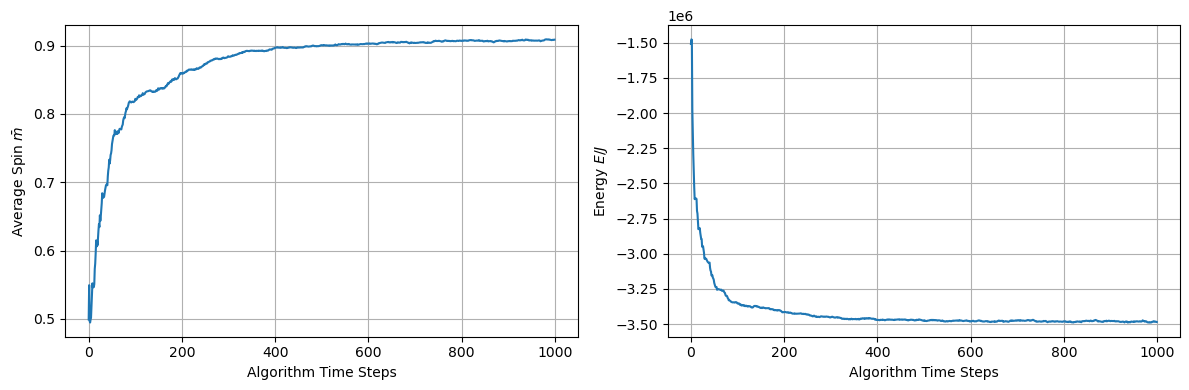

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins[:,1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies[:,1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

We can get $\bar{m}$ and $E/J$ for many different values of $\beta J$. The values will be the average of the last 100 points on the figure above.

In [31]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, energies_avg, energies_std

# BJ is just betaa = 1/kbT
BJs = 1/torch.linspace(1, 3, 20).to(device) 
spins_avg_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

Can look at $\bar{m}$ as a function of temperature $T = 1/\beta k = J/(\beta J)k$

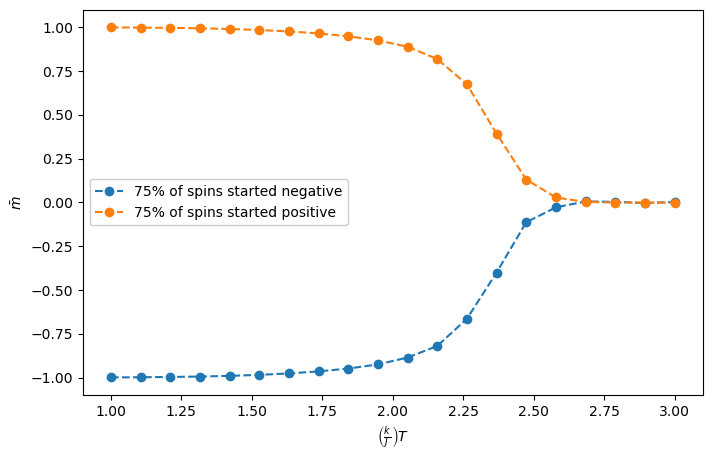

In [32]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs.cpu(), spins_avg_n.cpu(), 'o--', label='75% of spins started negative')
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

# We see that at higher energies, at critical temperature the spins go
#  from being aligned to being dissalligned, a PHASE CHANGE

# The 3D Ising Model

Because we're in 3D, we need to significantly reduce the size of our lattice.

In [44]:
N = 150
N = 50

Create the initial lattice like before

In [45]:
init_random = torch.rand((N,N,N)).to(device)
lattice_p = torch.zeros((N,N,N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

Functions to compute the energy for each element in the lattice, the total energy of the lattice, and $\Delta E$ for each element in the lattice (if the spin were to flip)

In [46]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(3, 1) 
    # now it's a 3D kernel up down front back and conv3d now
    kern[1][1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattice * conv3d(lattice, kern, padding='same')
    return arr
    
def get_energy(lattice):
    # applies the nearest neighbours summation
    return get_energy_arr(lattice).sum(axis=(2,3,4)).squeeze()

def get_dE_arr(lattice):
    return -2*get_energy_arr(lattice)

Create a batch of initial lattices to be ran in the metropolis function/

In [47]:
lattices = torch.stack([lattice_p, lattice_p]).unsqueeze(dim=1)

In [48]:
lattices.shape  # torch.Size([2, 1, 150, 150, 150])

torch.Size([2, 1, 50, 50, 50])

The metropolis function in 3D

In [49]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        k = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2,k::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2,k::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3,4))/N**3)
    return torch.vstack(avg_spins), torch.vstack(energies)

# all of the same things as before but in 3D

This function takes in an initial 3D lattice, and solves for average spin and energy at all the different temperatures specified by the $\beta J$ array values

In [50]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, energies_avg, energies_std

Get temperatures and statistics

In [51]:
BJs = 1/torch.linspace(3, 5.5, 20).to(device)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

"""
OutOfMemoryError                          Traceback (most recent call last)
Cell In[40], line 2
      1 BJs = 1/torch.linspace(3, 5.5, 20).to(device)
----> 2 spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

Cell In[39], line 3
      1 def get_spin_energy(lattice, BJs):
      2     lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1,1)
----> 3     spins, energies = metropolis(lattices, 1000, BJs)
      4     spins_avg = torch.mean(spins[-400:], axis=0)
      5     energies_avg = torch.mean(energies[-400:], axis=0)

Cell In[38], line 10
      8 j = np.random.randint(0,2)
      9 k = np.random.randint(0,2)
---> 10 dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2,k::2]
     11 change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
     12 spin_tensor_batch[:,:,i::2,j::2,k::2][change] *=-1

Cell In[35], line 15
     14 def get_dE_arr(lattice):
---> 15     return -2*get_energy_arr(lattice)

Cell In[35], line 7
...
      6 kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
----> 7 arr = -lattice * conv3d(lattice, kern, padding='same')
      8 return arr

OutOfMemoryError: CUDA out of memory. Tried to allocate 258.00 MiB. GPU 
"""

According to https://arxiv.org/abs/2205.12357 (page 5) the accepted value for the critical temperature in the 3D Ising model is $\beta J = 0.221654626$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


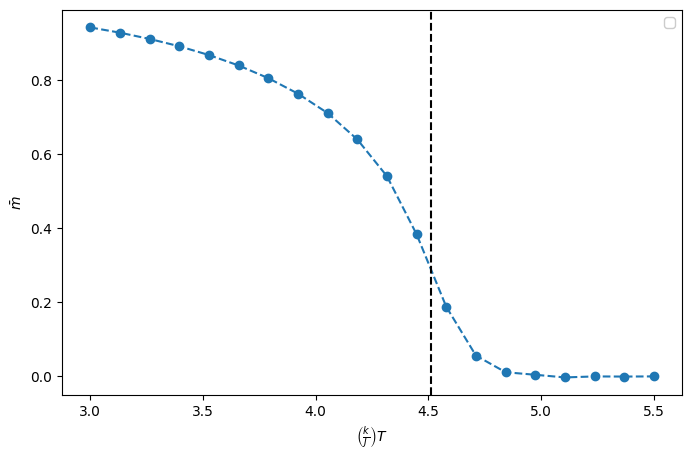

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--')
plt.axvline(1 / 0.221654626, color='k', ls='--')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

"""
The fun part is that you can solve the Ising model anallytically for 2D
 but not for 3D, we do it here numerically
"""